# MHNet Image Classifier for the MSL Dataset
This is a model for images captured by the Mars Hand camera on the Curiosity rover.

There are three parts:
1. Prepare Hardware and Data
2. Building and Training
3. Evaluation and Predictions

-Riley Knybel 7/16/2023

## Part 1/3: Prepare Hardware and Data

In [3]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
img_folder = "mh-images"

In [4]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
#count the images in the dataset
count = 0
cpt = sum([len(files) for r, d, files in os.walk(img_folder)])
print(str(cpt) + " total images in dataset")

2407 total images in dataset


In [6]:
#load the dataset using Keras

#SPLIT
#Train/Validate/Test
#70%/15%/15%

batch_size = 4
img_height = 227
img_width = 227

#training/validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    img_folder,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_and_test = tf.keras.utils.image_dataset_from_directory(
  img_folder,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds, test_ds = tf.keras.utils.split_dataset(val_and_test, left_size=0.5)

val_size = len(val_ds) * batch_size
test_size = len(test_ds) * batch_size

print("True validation size: " + str(val_size))
print("True test size: " + str(test_size))

Found 2407 files belonging to 13 classes.
Using 1685 files for training.
Found 2407 files belonging to 13 classes.
Using 722 files for validation.


2023-07-26 23:18:16.114918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:18:16.115152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:18:16.115262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True validation size: 364
True test size: 364


In [7]:
# show class names
class_names = train_ds.class_names
print(class_names)

['apxs cal target', 'chemin inlet open', 'drill holes', 'ground', 'horizon', 'inlet', 'mahli cal target', 'mastcam', 'mastcam cal target', 'observation tray', 'rems uv sensor', 'rover rear deck', 'wheel']


In [8]:
#normalize data - change pixel scale from 0-255 to 0-1
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.959194


## Part 2/3: Building and Training

In [9]:
#alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(14, activation='softmax')
])

In [10]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
#see the layers!
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [12]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)


In [13]:
#train the model, time to cook!

#repeat is used to make sure there is enough training data for 3000 iterations

epochs=6
steps_per_epoch=500
history = model.fit(
  train_ds.repeat(9),
  validation_data=val_ds.repeat(9),
  epochs=epochs,
  steps_per_epoch=steps_per_epoch
)

Epoch 1/6


/home/riley/.local/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-26 23:18:40.000141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-07-26 23:18:40.192630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-26 23:18:40.195222: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2f97c281b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 23:18:40.195247: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-26 23:18:40.198250: I ten

500/500 [==============================] - 20s 31ms/step - loss: 3.1691 - accuracy: 0.6765 - val_loss: 2.4930 - val_accuracy: 0.6482
Epoch 2/6
500/500 [==============================] - 15s 30ms/step - loss: 1.2902 - accuracy: 0.8338 - val_loss: 0.8336 - val_accuracy: 0.8837
Epoch 3/6
500/500 [==============================] - 15s 30ms/step - loss: 0.9445 - accuracy: 0.8828 - val_loss: 0.2220 - val_accuracy: 0.9557
Epoch 4/6
500/500 [==============================] - 15s 30ms/step - loss: 0.7390 - accuracy: 0.8953 - val_loss: 4.5823 - val_accuracy: 0.6177
Epoch 5/6
500/500 [==============================] - 15s 30ms/step - loss: 0.8785 - accuracy: 0.8878 - val_loss: 1.1071 - val_accuracy: 0.9058
Epoch 6/6
500/500 [==============================] - 15s 30ms/step - loss: 0.5156 - accuracy: 0.9273 - val_loss: 0.5351 - val_accuracy: 0.8864


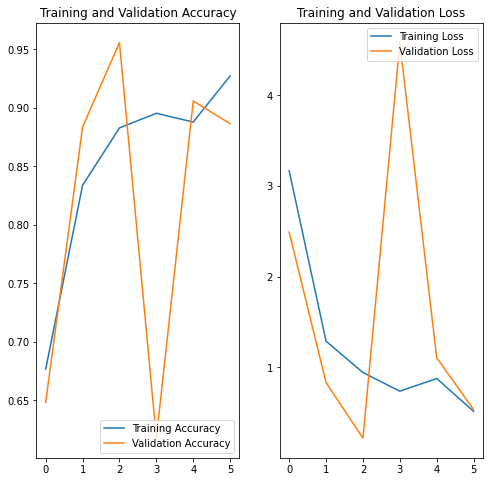

In [14]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [15]:
#evaluate the accuracy
score = model.evaluate(val_ds, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

score = model.evaluate(test_ds, verbose=0)
print("Test Loss: " + str(score[0]))
print("Test Accuracy: " + str(score[1]))

Validation Loss: 0.5351240634918213
Validation Accuracy: 0.886426568031311
Test Loss: 0.8316375017166138
Test Accuracy: 0.8642659187316895
